In [52]:
"""
This project is created for the Udacity program purpose
@author: hotronghai
"""
import pandas as pd

# % matplotlib inline

df_cal = pd.read_csv('./boston_data/calendar.csv')
df_listing = pd.read_csv('./boston_data/listings.csv')

# df_listing.head()
# print(df_cal.head())
df_cal.head()


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


### Prepare data
The data having some invalid format. So I want to build some functions that format and extract data from column
- `convert_to_date`: this function will convert data column which default `dtypes` is `object` to `datatime` value
- `convert_to_money`: Because data having $ sign as currency unit, it is difficult to compare or sum by value, we will remove $ sign and convert to `float` type
- `re_mapping` city: the data has some inconsistent data for `city`, for example `Boston (Charlestown)`, `Jamaica Plain (Boston)`..These values should be mapped with specified location (if any)


In [53]:
df_listing['city'].value_counts()

Boston                       3381
Roxbury Crossing               24
Somerville                     19
Jamaica Plain                  18
Brookline                      18
Cambridge                      16
Dorchester                     15
Brighton                       15
Charlestown                    15
Allston                        12
Roslindale                      6
West Roxbury                    5
ROXBURY CROSSING                4
East Boston                     3
Mattapan                        3
Boston, Massachusetts, US       2
South Boston                    2
Jamaica Plain                   2
Hyde Park                       2
Jamaica Plain, Boston           2
ALLSTON                         2
Milton                          1
South End, Boston               1
dorchester, boston              1
Jamaica Plain (Boston)          1
Boston                          1
boston                          1
Boston (Charlestown)            1
Mission Hill, Boston            1
Jamaica Plain,

In [54]:
def convert_to_date(df, date_field):
    df[date_field] = pd.to_datetime(df[date_field])
    # df_cal['date'].dt.month


def convert_to_money(df, money_fields):
    for money_field in money_fields:
        df[money_field] = df[money_field].replace('[\$,]', '', regex=True).astype(float)


def add_month(df, date_col, new_month_col="_month"):
    df[new_month_col] = df[date_col].dt.month


def is_any_null(df, col):
    return any(df[col].isnull())


def convert_to_city(df, city_field):
    def re_mapping(city):
        _d = {
            "Boston (Charlestown)": "Charlestown",
            "Jamaica Plain (Boston)": "Jamaica Plain",
            "Jamaica Plain, Boston": "Jamaica Plain",
            "Jamaica plain": "Jamaica Plain",
            "Jamaica Plain, MA": "Jamaica Plain",
            "Boston (Jamaica Plain)": "Jamaica Plain",
            "Boston, Massachusetts, Us": "Boston",
            "East Boston": "Boston",
            "Dorchester, Boston": "Dorchester",
            "Roslindale, Boston": "Roslindale",
            "波士顿": "Boston",
            "South End, Boston": "Boston",
            "Mission Hill, Boston": "Boston"
        }

        return _d[title(city)] if title(city) in _d else title(city)

    df[city_field] = df[city_field].astype(str)
    df[city_field] = df[city_field].apply(trim)
    df[city_field] = df[city_field].apply(re_mapping)


def trim(s):
    return s.strip()


def title(s):
    return s.title()


def merge_df_cal_listing(_df_cal, _df_listing):
    return pd.merge(_df_cal, _df_listing, how='inner', left_on=['listing_id'], right_on=['id'])


convert_to_date(df_cal, 'date')
convert_to_money(df_cal, ['price'])

convert_to_money(df_listing, ['price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people'])
convert_to_city(df_listing, 'city')

df_cal_listing = merge_df_cal_listing(df_cal, df_listing)



In [55]:
add_month(df=df_cal_listing, date_col="date", new_month_col="_month")
df_cal_listing['_month']

0          9
1          9
2          9
3          9
4          9
          ..
1308885    9
1308886    9
1308887    9
1308888    9
1308889    9
Name: _month, Length: 1308890, dtype: int64

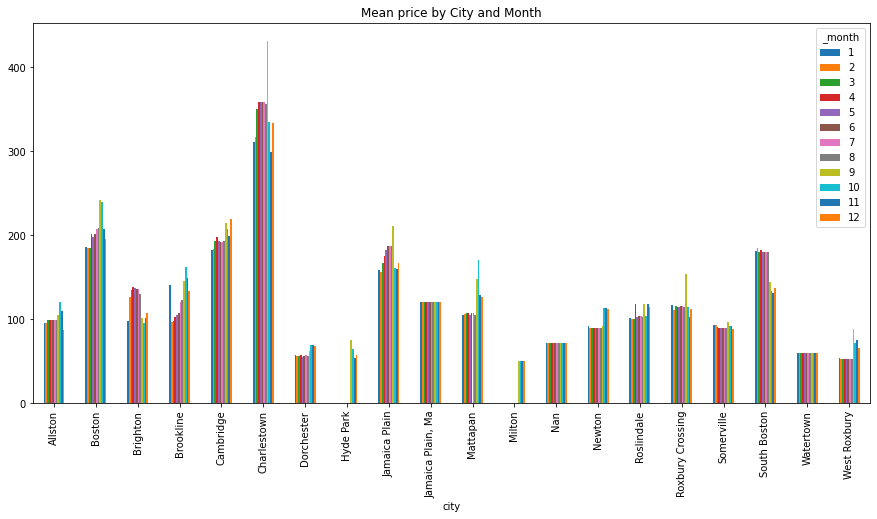

In [56]:
import matplotlib.pyplot as plt


def chart_price_by_city_and_month():
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.title("Mean price by City and Month")
    g_city_and_month = df_cal_listing.groupby(['city', '_month'])['price_x'].mean()
    g_city_and_month.unstack().plot(legend=True, kind='bar', ax=ax)

    plt.savefig('chart_price_by_city_and_month.png', dpi=100, bbox_inches='tight')


chart_price_by_city_and_month()

In [57]:
import numpy as np
from IPython.display import display


def _diff_percent(x):
    return (np.max(x) - np.min(x)) / np.min(x)


def _min_month(x):
    _indices = np.argmin(x)
    _rs = df_cal_listing.iloc[_indices]
    return _rs['_month']


def _max_month(x):
    _indices = np.argmax(x)
    _rs = df_cal_listing.iloc[_indices]
    return _rs['_month']


def print_max_min_price_by_city():
    g_max_min = df_cal_listing.groupby(['city']).agg({
        'price_x': ['mean', 'min', 'max', _diff_percent, _min_month, _max_month],
        # '_month': 'first'
    })

    # g_max_min.to_markdown()
    display(g_max_min)


print_max_min_price_by_city()

price_x                                          \
                         mean    min     max _diff_percent _min_month   
city                                                                    
Allston             99.167632   32.0   295.0      8.218750       10.0   
Boston             202.449585   11.0  7163.0    650.181818        6.0   
Brighton           120.593124   50.0   500.0      9.000000        7.0   
Brookline          127.450736   39.0   409.0      9.487179        6.0   
Cambridge          197.659038   72.0   959.0     12.319444       10.0   
Charlestown        340.640029  100.0  1000.0      9.000000       10.0   
Dorchester          59.140617   22.0   399.0     17.136364       10.0   
Hyde Park           63.230088   50.0    75.0      0.500000       11.0   
Jamaica Plain      174.221162   60.0   450.0      6.500000        9.0   
Jamaica Plain, Ma  120.000000  120.0   120.0      0.000000        9.0   
Mattapan           112.664474   75.0   330.0      3.400000        9.0   
Milton              50.000000   50.0    50.0      0.000000        5.0   
Nan                 71.504814   68.0    75.0      0.102941        8.0   
Newton              95.670732   90.0   116.0      0.288889        9.0   
Roslindale         106.328404   58.0   400.0      5.896552        9.0   
Roxbury Crossing   114.582674   20.0   350.0     16.500000        9.0   
Somerville          91.009037   36.0   249.0      5.916667        5.0   
South Boston       167.014286   89.0   335.0      2.764045        9.0   
Watertown           60.000000   60.0    60.0      0.000000        9.0   
West Roxbury        60.916335   48.0   175.0      2.645833        5.0   

                              
                  _max_month  
city                          
Allston                  4.0  
Boston                  10.0  
Brighton                 9.0  
Brookline               12.0  
Cambridge                2.0  
Charlestown              9.0  
Dorchester               4.0  
Hyde Park                4.0  
Jamaica Plain            9.0  
Jamaica Plain, Ma        9.0  
Mattapan                 5.0  
Milton                   5.0  
Nan                      9.0  
Newton                   6.0  
Roslindale               5.0  
Roxbury Crossing         9.0  
Somerville               9.0  
South Boston             1.0  
Watertown                9.0  
West Roxbury             9.0

### Question 1: Earning in time frames and areas
- In the chart we can see Chartlestown city has highest price (mean 340$/day) and West Roxbury has lowest price in every month.
- There are some cities having stable price in all months: Watertown, Milton
- Except Boston (common location), there are some city have big diffirent in day and month. Min price at Oct and Max price at Apr
    - Dorchester has low price at 22$/day



- Sep: almost with hight price
- Chartlestown with highest price

### Properties that predict price


In [58]:
from datetime import date


def choose_features():
    # host_since: date
    return ['host_has_profile_pic', 'host_identity_verified', 'city', 'accommodates', 'bathrooms',
            'bedrooms', 'beds', 'bed_type', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
            'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
            'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location', 'review_scores_value', 'cancellation_policy',
            'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count',
            'reviews_per_month', 'price']


def prepare_data(df_listing):
    def _get_since_days(since):
        now = date.today()
        return (now - since).days

    def _fill_mean(col):
        return col.fillna(col.mean())

    def _convert_bool(v):
        return 1 if str(v).lower() == 't' else 0

    def _expand_category_columns(_df, _cat_cols):
        for cat_col in _cat_cols:
            try:
                _df = pd.concat([_df.drop(cat_col, axis=1),
                                 pd.get_dummies(_df[cat_col], prefix=cat_col, prefix_sep='_', drop_first=True,
                                                dummy_na=True)], axis=1)
            except:
                continue
        return _df

    def _expand_feature_groupby(_df: pd.DataFrame, group_field='city'):
        num_cols = _df.select_dtypes(include=['float', 'int']).columns

        for num_col in num_cols:
            _g_df = _df.groupby(group_field).agg(
                {num_col: ['mean', 'max', 'min']}
            )

            _df = pd.merge(_df, _g_df, on=group_field)

        return _df

    def _expand_feature_common_func(_df: pd.DataFrame, funcs):
        num_cols = _df.select_dtypes(include=['float', 'int']).columns
        for num_col in num_cols:
            for func in funcs:
                _df[f"{num_cols}_{str(func)}"] = _df[num_col].apply(func)

        return _df

    def _expand_feature_composed(_df: pd.DataFrame):
        num_cols = _df.select_dtypes(include=['float', 'int']).columns
        for col_1 in num_cols:
            for col_2 in num_cols:
                _df[f"{col_1}_and_{col_2}"] = _df[col_1] * _df[col_2]

        return _df

    # convert_to_date(df_listing, 'host_since')
    # df_listing['_since_year'] = df_listing['_since_year'].apply(_get_since_days)

    df_listing.dropna(subset=['price'], axis=0)

    for c in ['host_has_profile_pic', 'host_identity_verified', 'require_guest_profile_picture',
              'require_guest_phone_verification']:
        df_listing[c] = df_listing[c].apply(_convert_bool)

    convert_to_money(df_listing, ['price'])

    for c in ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights',
              'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
              'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
              'review_scores_communication', 'review_scores_location', 'review_scores_value',
              'calculated_host_listings_count', 'reviews_per_month'
              ]:
        df_listing[c] = _fill_mean(df_listing[c])

    _df = df_listing[choose_features()]

    _df = _expand_feature_groupby(_df, group_field='city')

    _df = _expand_feature_common_func(_df, funcs=[np.log, np.sqrt, np.min, np.square])

    _df = _expand_feature_composed(_df)

    _df = _expand_category_columns(_df, ['city', 'bed_type', 'cancellation_policy'])
    # _df = _df.drop(['city', 'bed_type', 'cancellation_policy'], axis=1)

    return _df


cleaned_df = prepare_data(df_listing)



c:\users\haiht\appdata\local\programs\python\python37\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


In [59]:
X = cleaned_df.drop('price', axis=1)
y = cleaned_df['price']


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=37)

In [61]:

lm_model = LinearRegression(normalize=True)
# lm_model = TransformedTargetRegressor(
#         regressor=regressor,
#         func=np.log, inverse_func=np.exp)
# Instantiate
lm_model.fit(X_train, y_train)  #Fit

LinearRegression(normalize=True)

In [62]:
#Predict using your model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test)

#Score using your model
train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print((train_score, test_score))


(1.0, 0.9999999065964312)


In [ ]:
import seaborn as sns

sns.heatmap(cleaned_df.corr())
plt.savefig('./images/headmap_cleaned_df_2.png', dpi=1000)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_test_preds))
